# Cyclists Dataset Understanding

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import random
import math
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [4]:
races = pd.read_csv("../data/races.csv")

In [5]:
dataset = pd.read_csv("../data/cyclists.csv")
dataset.head()

,_url,name,birth_year,weight,height,nationality
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy
1,gerard-rue,Gérard Rué,1965.0,74.0,182.0,France
2,jan-maas,Jan Maas,1996.0,69.0,189.0,Netherlands
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.0,192.0,Belgium
4,jose-felix-parra,José Félix Parra,1997.0,55.0,171.0,Spain


## Syntactic and Semantic accuracies analysis

In questa sezione verifichiamo informazioni generiche sui nostri dati. Abbiamo studiato il tipo degli attributi, verificato come questi tipi possano essere cambiati qualora non sinao idonei al dominio degli attributi e abbiamo verificato che i valori non NaN presenti nel dataset risultino all'interno dei rispettivi domini

In [6]:
dataset.info()
# birth year, heigth -> float to int

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6134 non-null   object 
 1   name         6134 non-null   object 
 2   birth_year   6121 non-null   float64
 3   weight       3078 non-null   float64
 4   height       3143 non-null   float64
 5   nationality  6133 non-null   object 
dtypes: float64(3), object(3)
memory usage: 287.7+ KB


In [24]:
# birth_year è logicamente un intero mentre altezza e peso possono ragionevolmente essere considerati float
dataset['birth_year'] = dataset[dataset['birth_year'].notnull()]['birth_year'].astype(int)

In [22]:
dataset.describe()

,birth_year,weight,height
count,6126.000000,3078.000000,3143.000000
mean,1974.066275,68.658739,179.815145
std,15.536065,6.348183,6.443447
min,1933.000000,48.000000,154.000000
25%,1962.000000,64.000000,175.000000
50%,1974.000000,69.000000,180.000000
75%,1987.000000,73.000000,184.000000
max,2004.000000,94.000000,204.000000


## Completeness Analysis 

In questa sezione studiamo la completezza del dataset con particolare attenzione alla presenza di valori NaN o valori di default che possono nascondere i primi

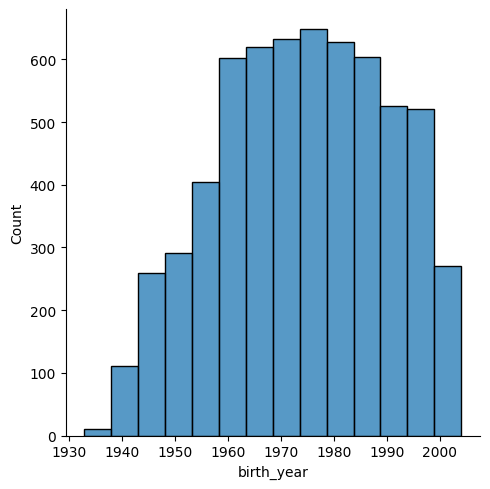

In [16]:
n_bins = math.ceil(math.log2(len(dataset)) + 1)

sb.displot(dataset, 
                x="birth_year", 
                kind="hist",
                row_order="desc",
                bins=n_bins) #TODO: cambia nome dell'asse x

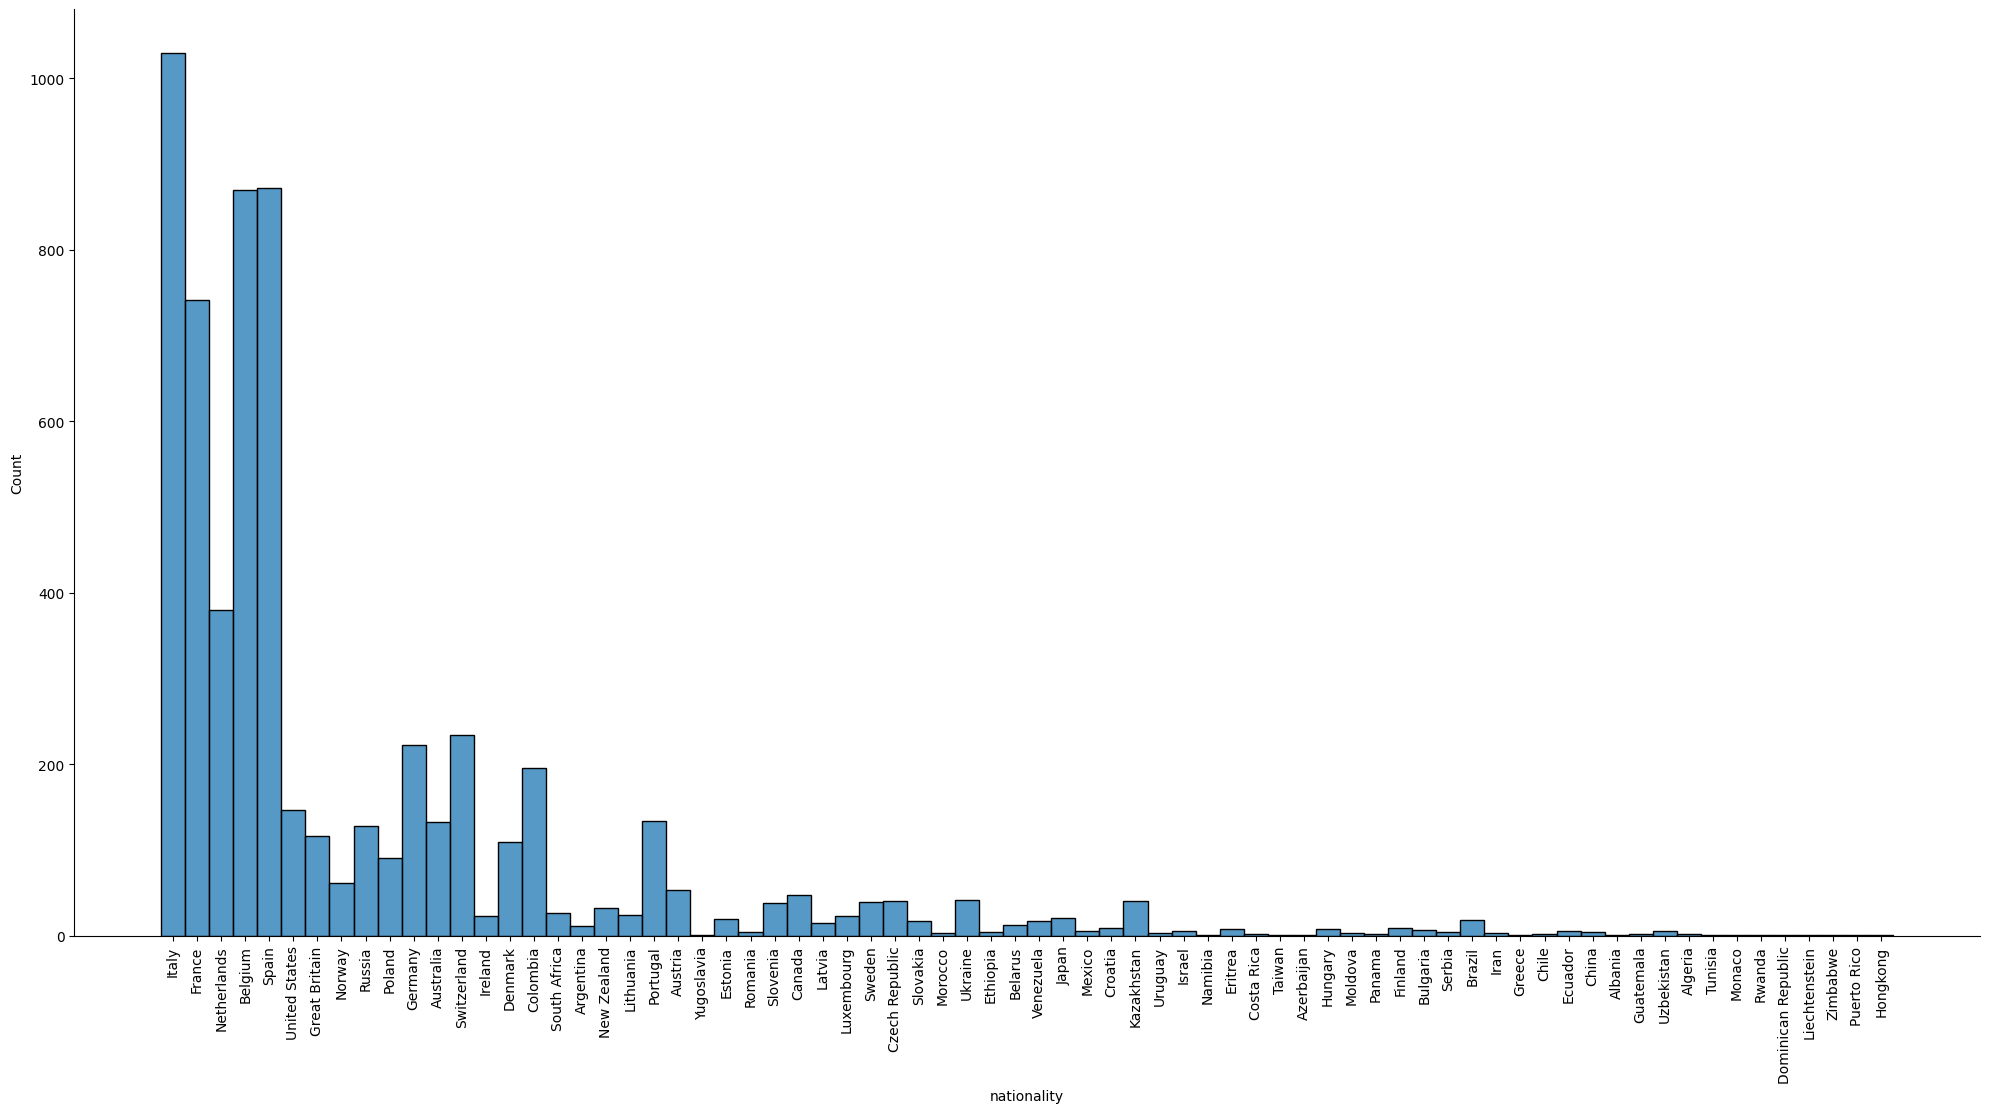

In [17]:
sb.displot(dataset, 
                x="nationality", 
                kind="hist",
                row_order="desc",
                bins=len(dataset['nationality'].unique()),
                height=10,
                aspect=2)
plt.xticks(rotation=90);

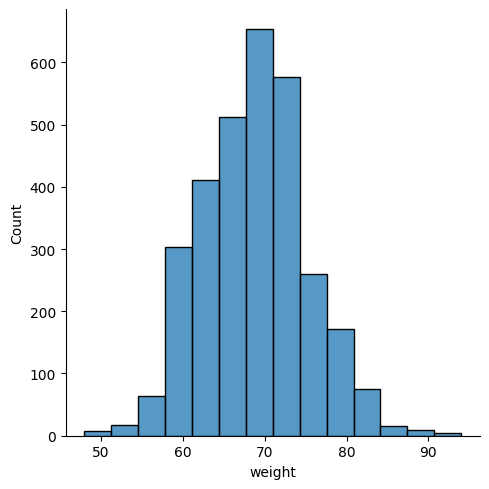

In [19]:
sb.displot(dataset, 
                x="weight", 
                kind="hist",
                row_order="desc",
                bins=n_bins)

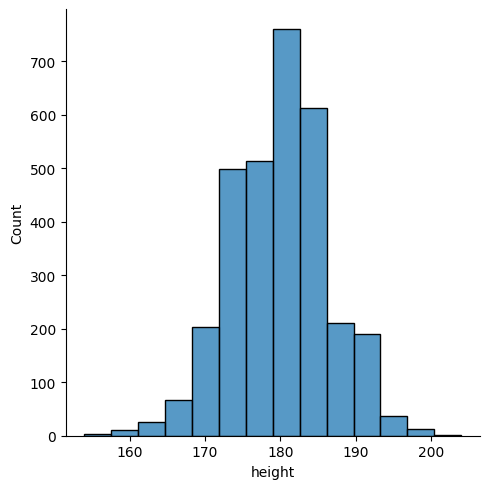

In [20]:
sb.displot(dataset, 
                x="height", 
                kind="hist",
                row_order="desc",
                bins=n_bins)

Guardando i grafici precedenti è possibile ricercare la presenza di valori di default che nascondono mancanze nel dataset. Abbiamo rilevato che la distribuzione dei valori è simile a quella che ci potremmo attendere, se ci fosse stato un valore di default la sua frequenza sarebbe stata fuori scala. Da questo momento in poi considereremo questi attributi come privi di valori di default.

### Analisi dei NaN values

In [7]:
dataset.isnull().sum()

_url              0
name              0
birth_year       13
weight         3056
height         2991
nationality       1
dtype: int64

In [8]:
percent_missing = dataset.isnull().sum() * 100 / len(dataset) # compute the percentage of missing values
missing_value_df = pd.DataFrame({'column_name': dataset.columns,
                                 'percent_missing': percent_missing})

missing_value_df['percent_missing']

_url            0.000000
name            0.000000
birth_year      0.211933
weight         49.820672
height         48.761004
nationality     0.016303
Name: percent_missing, dtype: float64

In [9]:
missing_birthyear = dataset[dataset['birth_year'].isnull()]['_url'].to_list()
dataset[dataset['birth_year'].isnull()]

,_url,name,birth_year,weight,height,nationality
9,scott-davies,Scott Davies,NaN,NaN,NaN,NaN
601,vladimir-malakov,Vladimir Malakov,NaN,NaN,NaN,Russia
894,antonio-zanini,Antonio Zanini,NaN,NaN,NaN,Italy
2408,filippo-simonetti,Filippo Simonetti,NaN,NaN,NaN,Italy
2515,carlos-garcia,Carlos García,NaN,NaN,NaN,Spain
2536,alexandr-osipov,Alexandr Osipov,NaN,NaN,NaN,Russia
3046,nicolai-kosyakov,Nicolai Kosyakov,NaN,NaN,NaN,Russia
3551,nevens-guy,Guy Nevens,NaN,NaN,NaN,Belgium
4142,oscar-pumar,Oscar Pumar,NaN,NaN,NaN,Venezuela
4384,javier-luquin,Javier Luquin,NaN,NaN,NaN,Spain


## Imputation

### Tentativo di imputazione manuale delle date di nascita mancanti sfruttando i dati del dataset 'races.csv'

I ciclisti nel dataset 'cyclist.csv' hanno età NaN in ogni record del dataset 'races.csv'

In [10]:
# cyclist
tmp_df = races[races['cyclist'].isin(missing_birthyear)]
tmp_df[tmp_df['cyclist_age'].notnull()]

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta


Abbiamo cercato di recuperare più dati possibile manualmente attraverso ricerce online supportate da confronti diretti con altri dati presenti nel dataset 'races.csv'

Una volta identificato un ciclista con alta probabilità abbiamo fatto una imputazione manuale del valore ottenuto nella feature 'birth_year' corrispondente

In [11]:
dataset.loc[dataset['_url'] == 'scott-davies', 'birth_year'] = 1995
dataset.loc[dataset['_url'] == 'vladimir-malakov', 'birth_year'] = 1958
dataset.loc[dataset['_url'] == 'antonio-zanini', 'birth_year'] = 1965
dataset.loc[dataset['_url'] == 'nevens-guy', 'birth_year'] = 1962
dataset.loc[dataset['_url'] == 'sergei-jermachenko', 'birth_year'] = 1956 

Ragionamento simile fatto anche per la nazionalità. L'unica mancante apparteneva al ciclista Scott Davies che era già stato correttamente identificato nella fase precedente, grazie a cui abbiamo rivenuto anche questa informazione

In [12]:
dataset.loc[dataset['_url'] == 'scott-davies', 'nationality'] = 'Great Britain'

In [13]:
dataset.isnull().sum() # check if missing values are filled correctly

_url              0
name              0
birth_year        8
weight         3056
height         2991
nationality       0
dtype: int64

### Imputation per altezza e peso

La nostra ipotesi di partenza è che altezza peso e nazionalità siano correlati. Desidereremmo sfruttare questa informazione per eseguire una imputazione di vicinanza nei record incompleti. 

Per poter procedere con questa strategia è essenziale stabilire le reali correlazioni tra questi attributi (confermando o smentendo quelle attese o scoprendone di nuove)

In [14]:
dataset[dataset['height'].isnull() & dataset['weight'].isnull()]

,_url,name,birth_year,weight,height,nationality
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy
6,willy-moonen,Willy Moonen,1947.0,NaN,NaN,Belgium
9,scott-davies,Scott Davies,1995.0,NaN,NaN,Great Britain
10,stian-remme,Stian Remme,1982.0,NaN,NaN,Norway
13,evgueny-anachkine,Evgueny Anachkine,1970.0,NaN,NaN,Russia
...,...,...,...,...,...,...
6123,francisque-teyssier,Francisque Teyssier,1969.0,NaN,NaN,France
6127,hendrik-van-dyck,Hendrik Van Dyck,1974.0,NaN,NaN,Belgium
6128,francisco-jose-pacheco,Francisco José Pacheco,1982.0,NaN,NaN,Spain
6129,juan-jose-martinez-diaz,Juan José Martínez,1966.0,NaN,NaN,Spain


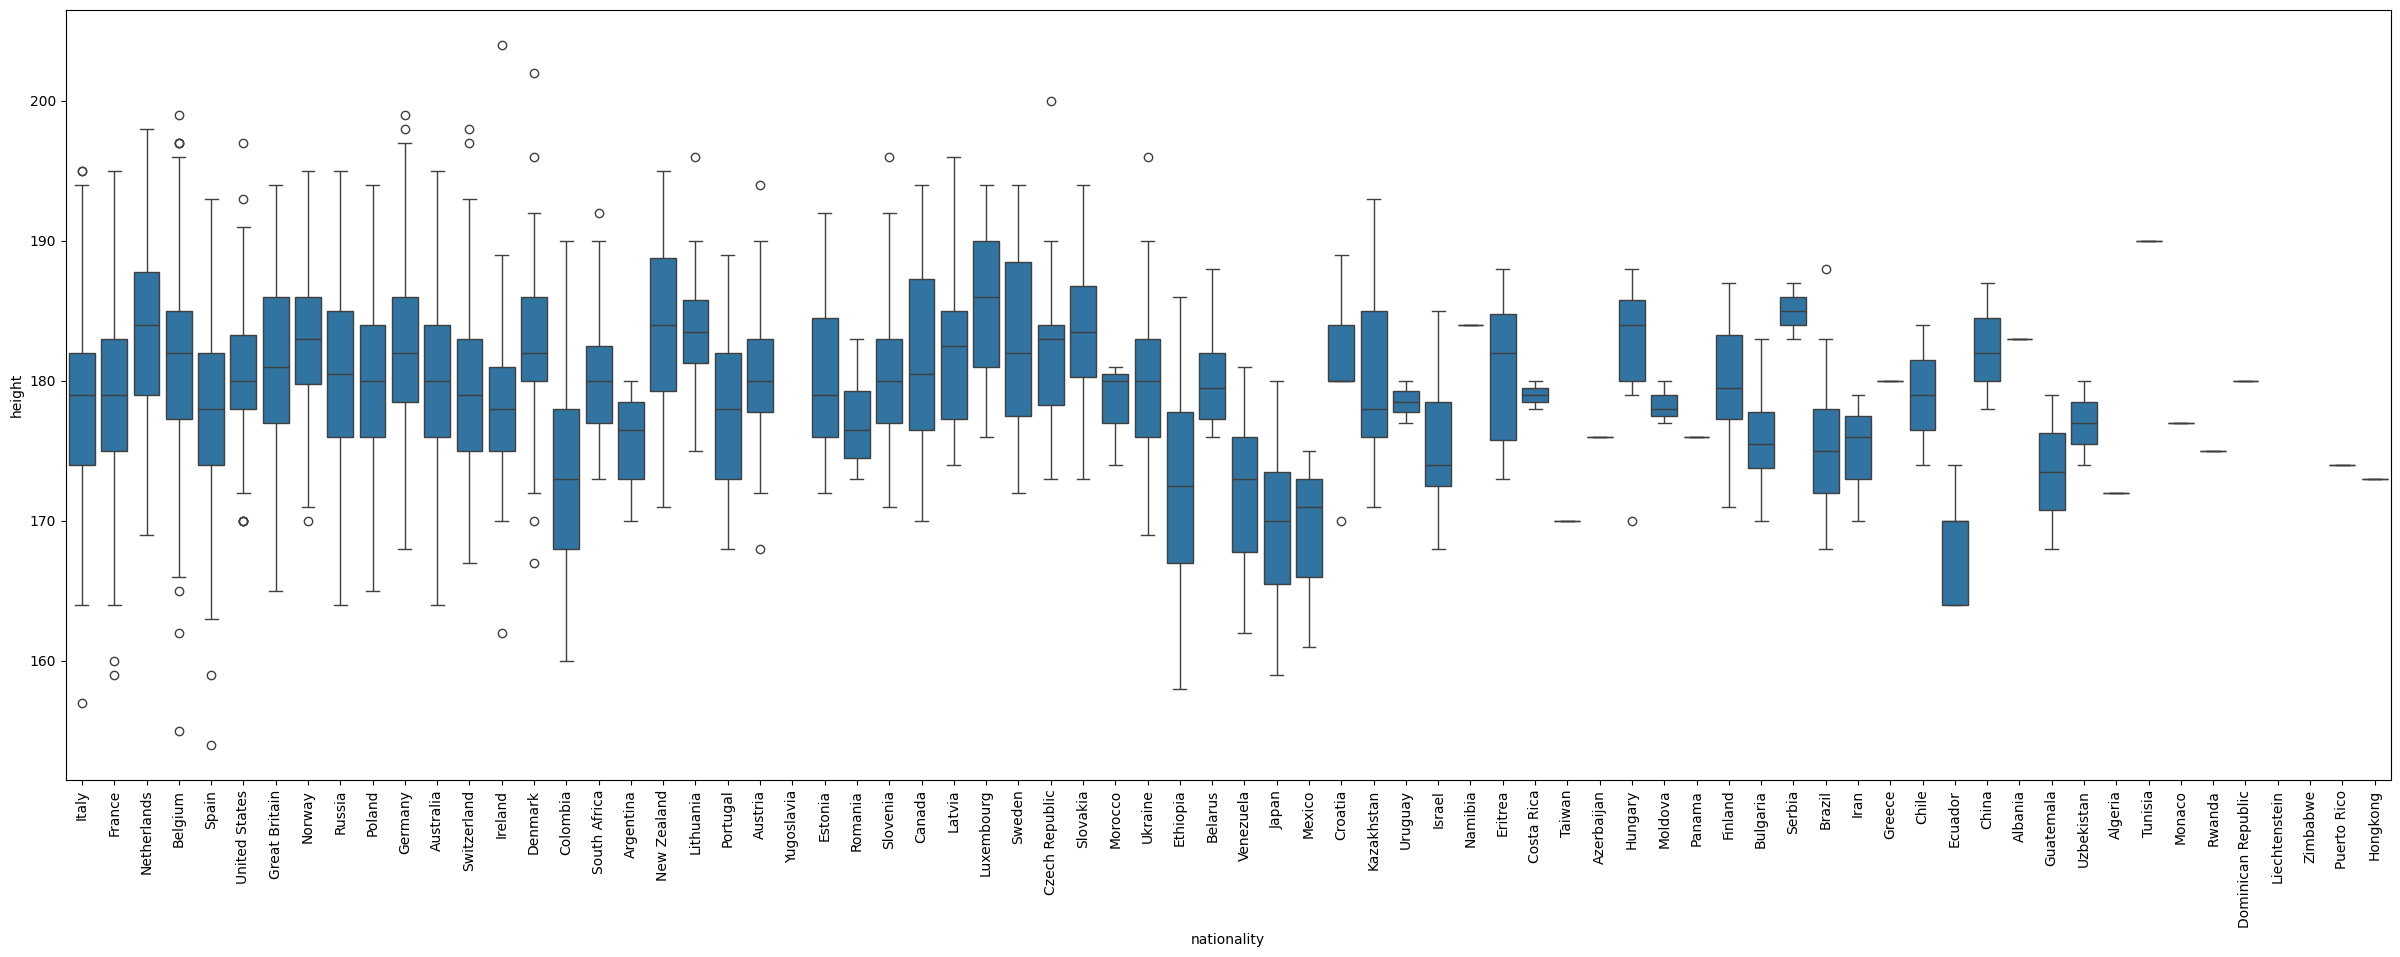

In [18]:
plt.figure(figsize=(30, 10))
sb.boxplot(x='nationality', y='height', data=dataset)
plt.xticks(rotation=90);
plt.show()

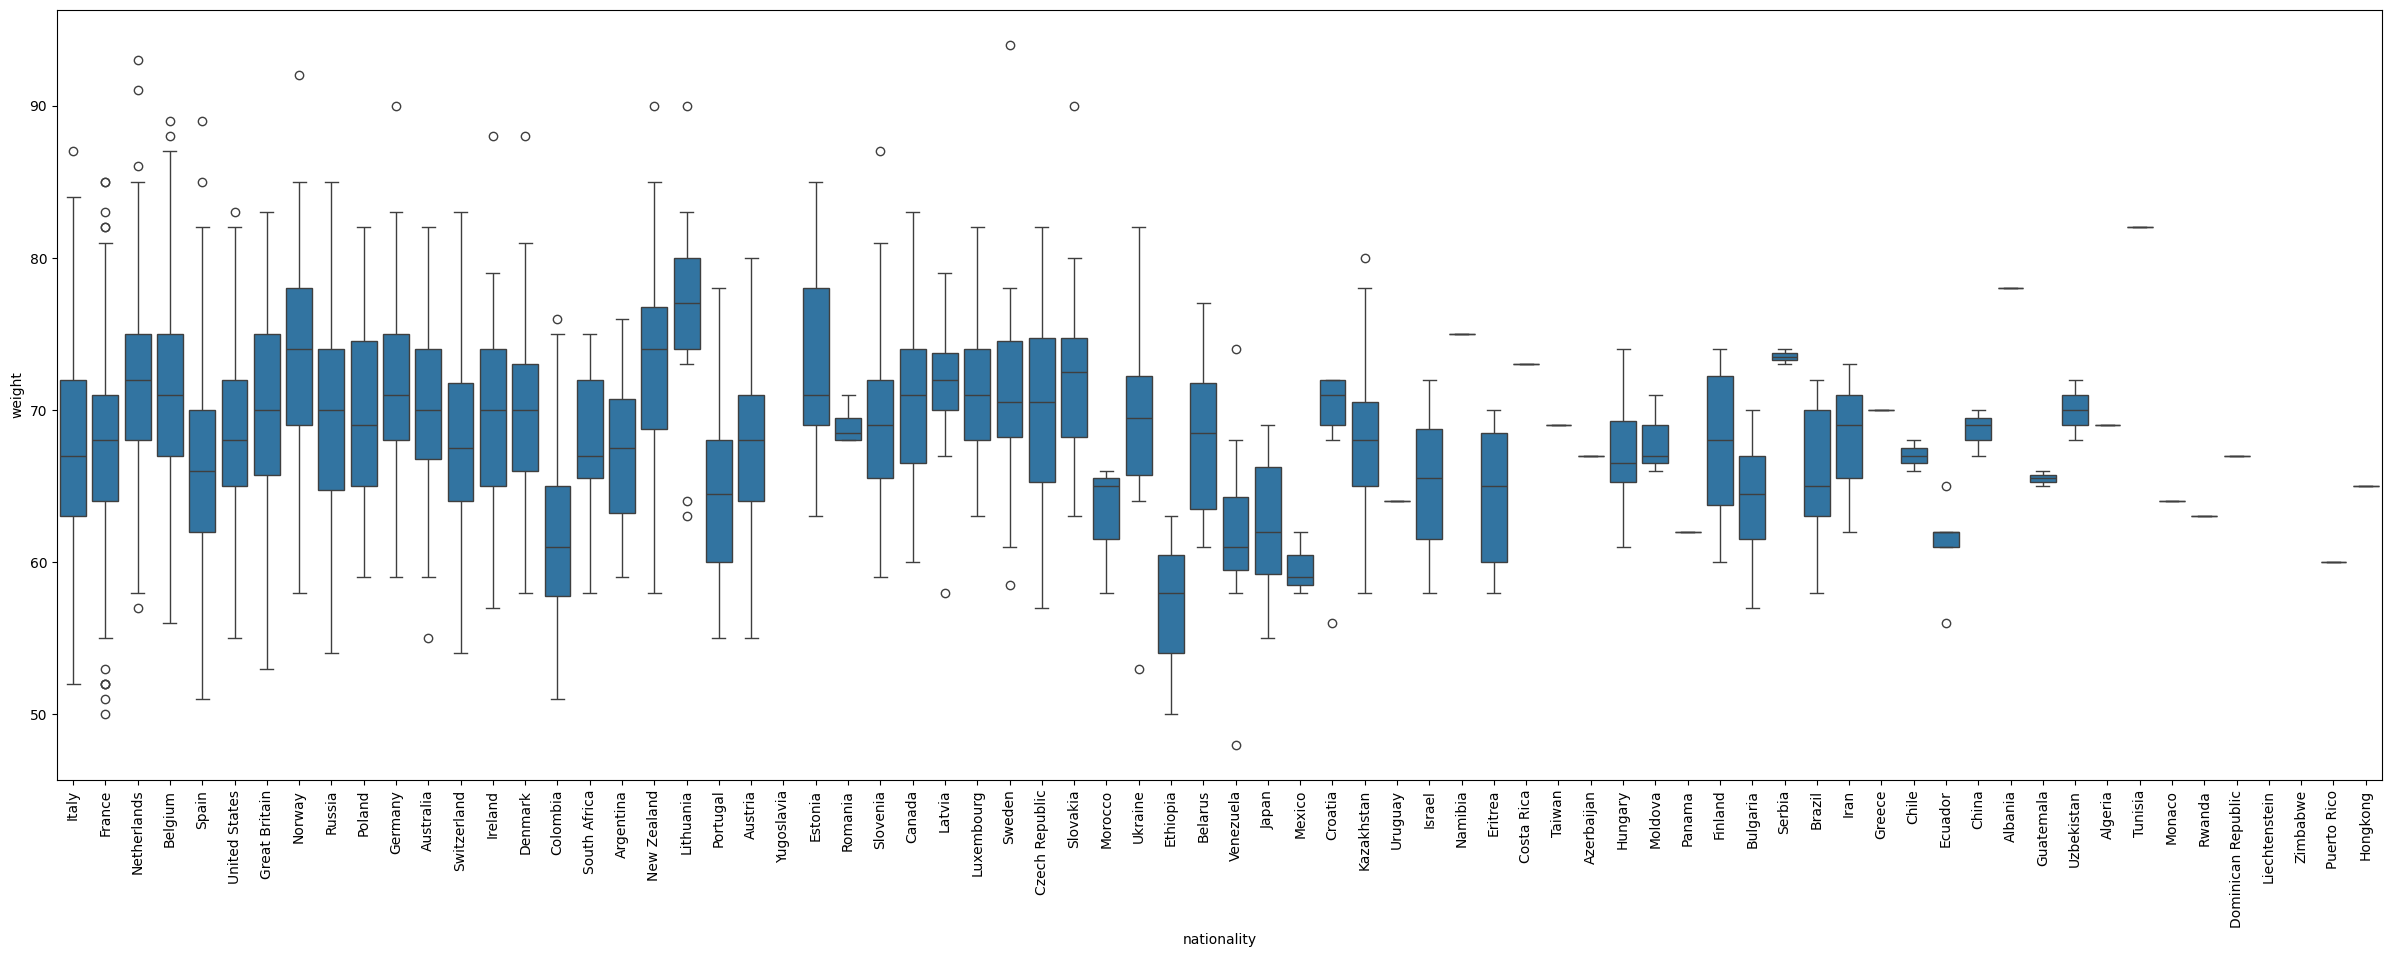

In [26]:
plt.figure(figsize=(30, 10))
sb.boxplot(x='nationality', y='weight', data=dataset)
plt.xticks(rotation=90);
plt.show()

Dall'analisi qualitativa di questo boxplot emerge che distinguendo per nazionalità le distribuzioni probabilistiche degli attributi altezza e peso non siano particolarmente diversificate. Le poche differenze che possiamo notare (ad esempio Ecuador rispetto a Cina) non sono supportate da una sufficiente quantità di record (confronto tra 5 e 4 ciclisti).

Il tipo di imputazione che abbiamo ipotizzato in precedenza non sarebbe quindi sufficientemente efficace e potrebbe anzi produrre bias "peggiori" rispetto ad altri tipi di imputazione più semplce (come quella statistica). Procederemmo quindi sostituendo le altezze e i pesi mancanti con un'estrazione di valori casuali dalla distribuzione globale degli attributi

Obiettivo, sostituire i valori mantenendo la distribuzione

In [19]:
N = len(dataset[dataset['height'].notnull()])
bins = int(1 + 10/3 * math.log10(N))

dataset['height_discretized'] = pd.cut(dataset['height'], bins=bins, labels=[i for i in range(1, bins+1)])

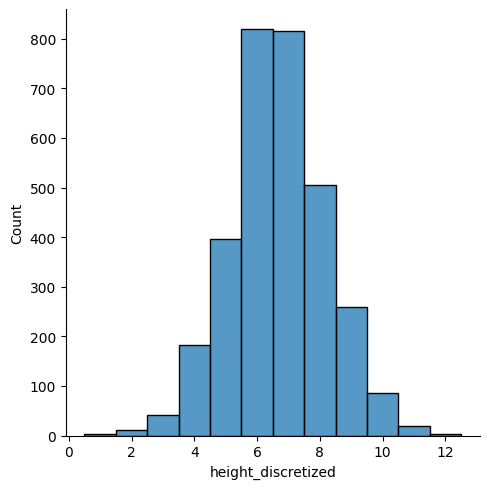

In [20]:
sb.displot(dataset, 
                x="height_discretized", 
                kind="hist",
                row_order="desc",
                bins=len(dataset['height_discretized'].unique()))

In [21]:
dataset['height_discretized'].value_counts(normalize=True).sort_index()
# probabilità di ogni classe di altezza

height_discretized
1     0.001273
2     0.003818
3     0.013045
4     0.058225
5     0.125994
6     0.260579
7     0.259625
8     0.160675
9     0.082405
10    0.027362
11    0.006045
12    0.000955
Name: proportion, dtype: float64

In [22]:
probabilities = dataset['height_discretized'].value_counts(normalize=True).sort_index().to_list()
print(probabilities)
classes = [i for i in range(1, bins+1)] # the values to be extracted

generator = np.random.default_rng(seed=None)

dataset['height_discretized'].fillna(generator.choice(a=classes, p=probabilities), inplace=True)
#TODO: risolvere problema della generazione randomica (il metodo 'choice' non sembra generare in modo corretto)

'''for index, row in dataset.iterrows():
    if pd.isnull(row['height_discretized']):
        p = random.uniform(0, 1)

        for i in range(len(probabilities)):
            if p <= probabilities[i]:
                print(f"index: {index}, p: {p}, i: {i}, class: {classes[i]}")
                dataset.at[index, 'height_discretized'] = classes[i]
                break'''

[0.0012726694241170856, 0.003818008272351257, 0.013044861597200128, 0.05822462615335666, 0.12599427298759147, 0.26057906458797325, 0.25962456251988547, 0.16067451479478206, 0.08240534521158129, 0.02736239261851734, 0.006045179764556157, 0.0009545020680878142]


/tmp/ipykernel_58841/2802081395.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['height_discretized'].fillna(generator.choice(a=classes, p=probabilities), inplace=True)


'for index, row in dataset.iterrows():\n    if pd.isnull(row[\'height_discretized\']):\n        p = random.uniform(0, 1)\n\n        for i in range(len(probabilities)):\n            if p <= probabilities[i]:\n                print(f"index: {index}, p: {p}, i: {i}, class: {classes[i]}")\n                dataset.at[index, \'height_discretized\'] = classes[i]\n                break'

In [23]:
dataset['height_discretized'].isnull().sum()

np.int64(0)

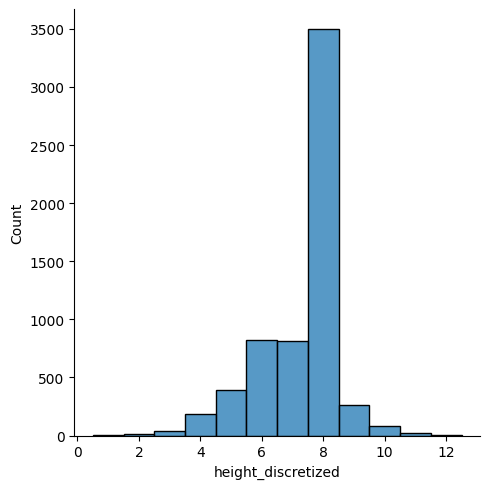

In [24]:
sb.displot(dataset, 
                x="height_discretized", 
                kind="hist",
                row_order="desc",
                bins=len(dataset['height_discretized'].unique()))